<a href="https://www.kaggle.com/ubiratanfilho/how-old-are-you-according-to-a-cnn?scriptVersionId=87081057" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction 📜
---

This notebook is a Data Science Project that aims to predict the age of people based on the 
[UTKFace Dataset](https://www.kaggle.com/abhikjha/utk-face-cropped). I will:

- Save and compress our Data in TFRecords files to improve our model speed. 🚀
- Resize our images and use a pretrained model to predict the age of each person in our dataset. 👀
- Build a streamlit app so that you can upload your photo and check how old you are according to a machine 🥸👧

Without further ado, let's start!

### Dependencies 💪

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from PIL import Image

# Reading Data 📕
----
Our Dataset has almost 24000 images. It's very big! To train our model, I will prepare our data and save as TFRecord files. TFRecords are the best way to storage huge amounts of data and use it to train Keras Models. You can check how and why to use it in: [A hands-on guide to TFRecords](https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c)

In [25]:
curdir = "../input/utkface-new/UTKFace"

In [26]:
dataset_filepaths = os.listdir(curdir)

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

In [28]:
np.random.shuffle(dataset_filepaths)

In [29]:
dataset_filepaths[0]

'85_0_0_20170111210408610.jpg.chip.jpg'

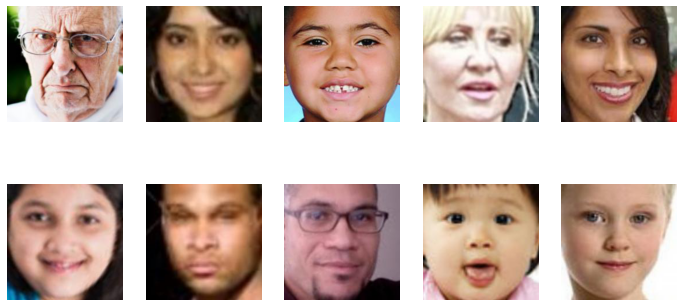

In [30]:
fig, ax = plt.subplots(2,5, figsize=(12, 6), sharex=True, sharey=True)
for image_idx in range(10):
    ax[image_idx//5, image_idx%5].imshow(Image.open(os.path.join(curdir,dataset_filepaths[image_idx])))
    ax[image_idx//5, image_idx%5].axis('off')
plt.show()

In [31]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

In [32]:
def create_example(folder_path, filepath):
    full_path = os.path.join(folder_path, filepath)
    image = tf.io.serialize_tensor(np.array(Image.open(full_path)))
    split = filepath.split("_")
    age = int(split[0])
    gender = int(split[1])
    
    example = Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image.numpy()])),
                "age": Feature(int64_list=Int64List(value=[age])),
            }
        )
    )
    return example

In [33]:
def create_tf_record(set_, filename):
    with tf.io.TFRecordWriter("%s.tfrecord" %filename) as f:
        for filepath in set_:
            if filepath != "utkcropped":
                example = create_example(curdir, filepath)
                f.write(example.SerializeToString())

In [34]:
train_range = [i for i in range(0,16597)]
valid_range = [i for i in range(16597,18968)]
test_range = [i for i in range(18968,len(dataset_filepaths)+1)]

In [35]:
create_tf_record(dataset_filepaths[:16597], "train_data")

In [36]:
create_tf_record(dataset_filepaths[16597:18968], "valid_data")

In [37]:
create_tf_record(dataset_filepaths[18968:], "test_data")

In [38]:
@tf.function
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "age": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[200, 200, 3])
    image = tf.image.resize(image, [224,224]) # reshape to the same dimensions as the training data of our pretrained model
    image = keras.applications.xception.preprocess_input(image)
    return image, example["age"]

def utkface_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [39]:
train_set = utkface_dataset("./train_data.tfrecord")
valid_set = utkface_dataset("./valid_data.tfrecord")
test_set = utkface_dataset("./test_data.tfrecord")

That's it! Now that we have saved our data in TFRecord files, let's use a pretrained model to predict our gender and age.

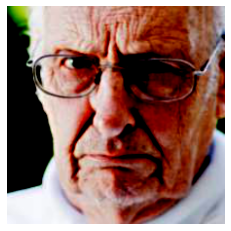

I am 85 years old!


2022-02-05 22:25:26.678242: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [40]:
for image, age in train_set.take(1):
    plt.imshow(image[0])
    plt.axis('off')
    plt.show()
    print("I am",age[0].numpy(), "years old!")


# Transfer Learning with Xception
-----

In [41]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="relu")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [42]:
for layer in base_model.layers: # freeze the weights of the base model
    layer.trainable = False
    
optimizer = keras.optimizers.Nadam(learning_rate=1e-4)
model.compile(loss="mean_squared_error", optimizer=optimizer,
              )
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=15)

Epoch 1/15
519/519 [==============================] - 52s 96ms/step - loss: 1172.3213 - val_loss: 899.3817
Epoch 2/15
519/519 [==============================] - 44s 85ms/step - loss: 737.4734 - val_loss: 590.8758
Epoch 3/15
519/519 [==============================] - 44s 85ms/step - loss: 514.1389 - val_loss: 436.8611
Epoch 4/15
519/519 [==============================] - 44s 85ms/step - loss: 401.2249 - val_loss: 360.2690
Epoch 5/15
519/519 [==============================] - 44s 85ms/step - loss: 341.6227 - val_loss: 318.6907
Epoch 6/15
519/519 [==============================] - 44s 85ms/step - loss: 306.3596 - val_loss: 292.6650
Epoch 7/15
519/519 [==============================] - 44s 85ms/step - loss: 282.8327 - val_loss: 274.3512
Epoch 8/15
519/519 [==============================] - 44s 85ms/step - loss: 265.8174 - val_loss: 260.5728
Epoch 9/15
519/519 [==============================] - 44s 86ms/step - loss: 252.9568 - val_loss: 249.8224
Epoch 10/15
519/519 [========================

In [43]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [44]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [45]:
for layer in base_model.layers: # unfreeze the weights and continue training
    layer.trainable = True

checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=100,
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

2022-02-05 22:42:55.717469: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-05 22:42:55.717510: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 1/100
      1/Unknown - 0s 92ms/step - loss: 176.9519

2022-02-05 22:42:56.026403: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-05 22:42:56.026671: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-02-05 22:42:56.417567: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-05 22:42:56.417616: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


      2/Unknown - 0s 313ms/step - loss: 133.7477

2022-02-05 22:42:56.829279: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-05 22:42:56.830003: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-02-05 22:42:56.966951: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 322 callback api events and 320 activity events. 
2022-02-05 22:42:56.975815: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-05 22:42:56.989959: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56

2022-02-05 22:42:56.997157: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56/fb70324f650b.trace.json.gz
2022-02-05 22:42:57.026554: I tensorflow/core/profiler/rpc/clien

      4/Unknown - 1s 281ms/step - loss: 157.7879

2022-02-05 22:42:57.031150: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56/fb70324f650b.memory_profile.json.gz
2022-02-05 22:42:57.032540: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56
Dumped tool data for xplane.pb to ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56/fb70324f650b.xplane.pb
Dumped tool data for overview_page.pb to ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56/fb70324f650b.overview_page.pb
Dumped tool data for input_pipeline.pb to ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56/fb70324f650b.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./my_logs/run_2022_02_05-22_42_55/train/plugins/profile/2022_02_05_22_42_56/fb70324f650

519/519 [==============================] - 45s 86ms/step - loss: 207.8048 - val_loss: 208.6942
Epoch 2/100
519/519 [==============================] - 44s 85ms/step - loss: 203.9895 - val_loss: 205.0763
Epoch 3/100
519/519 [==============================] - 44s 85ms/step - loss: 200.5211 - val_loss: 201.7915
Epoch 4/100
519/519 [==============================] - 44s 85ms/step - loss: 197.3536 - val_loss: 198.7907
Epoch 5/100
519/519 [==============================] - 44s 85ms/step - loss: 194.4540 - val_loss: 196.0397
Epoch 6/100
519/519 [==============================] - 44s 85ms/step - loss: 191.7981 - val_loss: 193.5309
Epoch 7/100
519/519 [==============================] - 44s 85ms/step - loss: 189.3589 - val_loss: 191.2353
Epoch 8/100
519/519 [==============================] - 49s 95ms/step - loss: 187.1133 - val_loss: 189.1281
Epoch 9/100
519/519 [==============================] - 49s 95ms/step - loss: 185.0415 - val_loss: 187.1892
Epoch 10/100
519/519 [===========================

In [46]:
model = keras.models.load_model('my_model.h5')

In [48]:
rmsq = tf.sqrt(model.evaluate(test_set))
rmsq

149/149 [==============================] - 11s 72ms/step - loss: 149.8978


<tf.Tensor: shape=(), dtype=float32, numpy=12.243277>

# Build our Streamlit App

Now it's time to build our Streamlit App so that you can check how old you are! I've learned how to use Streamlit in Kaggle notebook in [Streamlit App On Kaggle Notebooks](https://www.kaggle.com/ahmedshahriarsakib/streamlit-app-on-kaggle-notebook/notebook), make sure to check it out!